In [1]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.model_selection import KFold

In [2]:
with open('order_dict.json') as f:
    data = json.load(f)
with open('capstone_jd_msom_data-minus-click-data/warehouse_capacity.json') as f2:
    warehouse_capacity = json.load(f2)

In [3]:
capacity = {int(k):v[1] for k, v in warehouse_capacity.items()}

In [4]:
capacity

{57: 374.0,
 43: 3135.0,
 42: 3646.0,
 66: 139.0,
 20: 5329.0,
 58: 6226.0,
 15: 1429.0,
 6: 5177.0,
 2: 16037.0,
 64: 2164.0,
 14: 616.0,
 33: 4281.0,
 34: 2317.0,
 35: 2680.0,
 3: 14326.0,
 45: 2025.0,
 44: 2162.0,
 51: 892.0,
 63: 973.0,
 19: 936.0,
 4: 8593.0,
 12: 389.0,
 28: 4278.0,
 5: 21558.0,
 13: 666.0,
 55: 1549.0,
 54: 781.0,
 26: 4913.0,
 65: 1977.0,
 53: 1758.0,
 39: 3748.0,
 8: 672.0,
 46: 2264.0,
 31: 4825.0,
 67: 996.0,
 1: 1030.0,
 7: 14975.0,
 59: 9066.0,
 9: 23580.0,
 56: 2214.0,
 25: 2038.0,
 27: 12200.0,
 32: 3112.0,
 61: 1236.0,
 36: 3499.0,
 50: 2292.0,
 37: 2513.0,
 11: 898.0,
 10: 6057.0,
 38: 1420.0,
 47: 2039.0,
 40: 1163.0,
 41: 2352.0,
 52: 838.0,
 24: 5830.0,
 21: 743.0}

In [5]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}

In [6]:
def preprocessing(df_i):
    
    df = df_i.copy()
    df = df.fillna(0)
    df.replace(np.inf,0, inplace = True)

    # convert data type for categorical features
    df['cluster_id'] = df['cluster_id'].astype('object')
    df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
    df['day_of_week'] = df['day_of_week'].astype('object')

    cat = ['cluster_id','dc_ori_mode','day_of_week']
    num = df.drop(cat+['demand'], axis = 1).columns
    #print(num)
    
    
    # train test split
    df_enc = pd.get_dummies(df, columns = cat, drop_first = True)
    train_enc = df_enc.query('1<= day_of_month <= 24')
    test_enc = df_enc.query('24 < day_of_month <= 31')

    # train = df.query('1<= day_of_month <= 24')
    # test = df.query('24 < day_of_month <= 31')

    # train_enc = pd.get_dummies(train, columns = cat, drop_first = True)
    # test_enc = pd.get_dummies(test, columns = cat)

    # print(train_enc.dtypes)
    # print(test_enc.dtypes)

    # standardize data
    scaler = StandardScaler()

    # x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
    # x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]

    x_train = train_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1).to_numpy() # only remove highest vif column
    x_train = scaler.fit_transform(x_train)

    y_train = train_enc['demand'].to_numpy().reshape(len(train_enc), 1)


    x_test = test_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1) 
    x_test = scaler.fit_transform(x_test)

    y_test = test_enc['demand'].to_numpy().reshape(len(test_enc), 1)
    
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    return x_train, y_train, x_test, y_test

In [7]:
def r2_loss(outputs, targets):
    target_mean = torch.mean(targets)
    ss_tot = torch.sum((targets - target_mean) ** 2)
    ss_res = torch.sum((targets - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def r2_loss_2(outputs, targets):
    ss_tot = 0.0
    ss_res = 0.0
    target_mean = torch.mean(targets)
    for i in range(0,len(outputs)):
        ss_tot += (targets[i] - target_mean) ** 2
        ss_res += (targets[i] - outputs[i]) ** 2
    r2 = 1 - ss_res / ss_tot
    return r2

# TODO: need to work with tensor objects.
def SPOLoss (d_pred, d_actual):
    # W: items to stock the warehouse
    # h: inventory cost
    # s: shipping cost
    # ci: capacity limit for warehouse i = 1000 (per month)
    cost = 0.0
    max_capacity = capacity_i / 31 # capacity_i is defined outside of this function
    for i in range(0, len(d_pred)):
        if d_pred[i] <= max_capacity:
            w = d_pred[i]
        else:
            w = max_capacity
        if w > d_actual[i]:
            h = 2.920 * (w - d_actual[i])  # average inventory cost per sku * (w - target)
            s = 0
        else:
            h = 0
            s = 0.803 * (d_actual[i] - w)
        cost += h + s
    return cost

def SPO_MSE_Loss(d_pred, d_actual):
    spo_loss = SPOLoss(d_pred, d_actual)
    mse_loss = 0.0
    for i in range(0, len(d_pred)):
        mse_loss += (d_pred[i] - d_actual[i]) ** 2
    mse_loss = mse_loss / len(d_pred)
    # mse_loss = sum((d_pred - d_actual) ** 2) / len(d_pred)    # don't use this, because d_pred can is 1*N dimention but d_actual can be N*1 dimension
    return spo_loss + 0.1 * mse_loss
 
# print(torch.Tensor.float(1.0))
outputs = torch.randn(5)
targets = torch.randn(5)
# print(outputs.size())
# for i in range(0,len(outputs)):
#   print(2)
print(r2_loss(outputs,targets))
print(r2_loss_2(outputs,targets))
#print(SPOLoss(outputs,targets))
# print(torch.randn(5))
# print(SPOLoss(1, 2))

tensor(-5.0176)
tensor(-5.0176)


In [8]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [9]:
# define training and evaluation functions

def predict(model, x):
    
    """
    takes in a pytorch model and a matrix of features
    return a list of predictions
    """
    
    with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
        pred_y = model(Variable(torch.from_numpy(x).float())).data.numpy()
        pred_y = [pred_y[x].item() for x in range(len(pred_y))]
    return pred_y

def linearRegressionTrain(x_train, y_train, learningRate, epochs, loss_type = 'MSE', regularize = 'None', l1_penalty = 0, l2_penalty = 0, plot = True, verbose = True):
    """
    input: 
        - x_train whose type is numpy.ndarray
        - y_train whose type is numpy.ndarray
        - learningRate
        - epochs
        - regularization can be either "None" or "l1" or "l2", default is none
        - loss_type can be either "MSE" or "SPO" or "SPO_MSE", default is 'MSE'
        - plot: whether you want to plot the loss against epochs, default is True
        
    output:
        trained pytorch linear regression model
    """
    _, inputDim = x_train.shape
    outputDim = 1       # takes variable 'y'
    
    loss_list = []

    model = linearRegression(inputDim, outputDim)
    
    ##### For GPU #######
    # if torch.cuda.is_available():
    #     model.cuda()
    
    # initialize the loss function and optimizer
    if loss_type == 'MSE': 
        
        criterion = torch.nn.MSELoss()  
        # criterion = r2_loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.SGD(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    elif loss_type == 'SPO': # change loss function and switch to adam optimizer
        
        criterion = SPOLoss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    elif loss_type == 'SPO_MSE': # change loss function and switch to adam optimizer
        
        criterion = SPO_MSE_Loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    else:
        raise Exception('wrong loss_type')
        
    # model training

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        # if torch.cuda.is_available():
        #     inputs = Variable(torch.from_numpy(x_train).cuda())
        #     labels = Variable(torch.from_numpy(y_train).cuda())
        # else:
        #     inputs = Variable(torch.from_numpy(x_train))
        #     labels = Variable(torch.from_numpy(y_train))
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs.type(torch.FloatTensor))

        # get loss for the predicted output
        loss = criterion(outputs, labels.type(torch.FloatTensor))
        
        if regularize == 'l1':
            l1_norm = l1_penalty * torch.norm(model.linear.weight, p=1) # double check
            loss += l1_norm
            
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        # store loss
        loss_list.append(loss.data)

        # print loss
        #if(epoch % 100 == 0):
            #print('epoch {}, loss {}'.format(epoch, loss.data))
    
    if plot:
        plt.plot(range(epochs),loss_list)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt
        
    if verbose:
        print('model trained using {} loss'.format(loss_type))
        # bias b (offset or y-intercept)
        print('y-intercept ', model.linear.bias.item())
        # weight (w)
        print('Coefficients ',  model.linear.weight.detach().numpy())
    
        pred_y_train = predict(model, x_train)
        
        print("Train MSE =",mean_squared_error(y_train,pred_y_train))
        print('Train R^2 =', r2_score(y_train, pred_y_train)) 
        print('Train SPO Loss =', SPOLoss(pred_y_train, y_train))

    return model


def generate_scores(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    SPO = SPOLoss(y_pred, y_true)
    SPO_mean = SPO / len(y_pred)
    SPO_MSE = SPO_MSE_Loss(y_pred, y_true)
    SPO_MSE_mean = SPO_MSE / len(y_pred)
    #print("Train MSE =", MSE)
    #print('Train R^2 =', R2) 
    #print('Train SPO Loss =', SPO)
    return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO Loss': SPO, 'SPO_MSE_Weighted_Loss':SPO_MSE, 'SPO_MSE_Weighted_Loss Ave': SPO_MSE_mean, 'SPO Loss Ave': SPO_mean})

def evaluation(model, x_train, x_test, y_train, y_test, plot = True):
    
    """
    this function only works for pytorch model
    
    return a 2x4 dataframe: 
        - one row for training set, the other row for testing
        - 4 columns are 4 scores: MSE, R2, SPO, SPO Ave
    """

    pred_y_train = predict(model, x_train)
    pred_y_test = predict(model, x_test)

    # Comparing Actual and predicted values
    if plot:
        plt.figure(figsize=(7,7))
        plt.scatter(y_train, pred_y_train, c='b', s=10)
        plt.xlabel('Train Actual Demand'), plt.ylabel('Train Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

        plt.figure(figsize=(7,7))
        plt.scatter(y_test, pred_y_test, c='b', s=10)
        plt.xlabel('Test Actual Demand'), plt.ylabel('Test Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

    score_df = pd.concat([generate_scores(y_train, pred_y_train), generate_scores(y_test, pred_y_test)])
    score_df.index = ['train', 'test']
    
    return score_df

In [10]:
import timeit
def cross_validate(x_train, y_train, loss_type, regularize, plot = True):
    
    # return the best penalty coefficient that minimize average validation error
    start = timeit.default_timer()
    
    aveloss = dict()
    kfold = KFold(n_splits = 5)
    
    if loss_type == 'MSE':
        learningRate = 0.02
        epochs = 501
        grid = np.linspace(0,0.5,11) if regularize == 'l2' else np.linspace(0,1,11)
        
    elif loss_type == 'SPO':
        learningRate = 0.05
        epochs = 301
        grid = np.linspace(0,5,6) if regularize == 'l2' else np.linspace(0,10,6)
        

    if regularize == 'l2':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l2_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
            #print(i)
            
    elif regularize == 'l1':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l1_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
    else:
        raise Exception('wrong regularization type')
        
    if plot:
        plt.plot(aveloss.keys(), aveloss.values())
        plt.xlabel('penalty coefficient')
        plt.ylabel('average {} error on validation sets'.format(loss_type))
        plt.title('Cross Validation for {} Regularization'.format(regularize))
        plt.show()
        
    best = min(aveloss, key = aveloss.get)
    print('The best penalty coefficient is '+ str(best))
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    return best

In [11]:
i = 3
x_train, y_train, x_test, y_test = preprocessing(order_dict[i])
capacity_i = capacity[i] if i in capacity.keys() else pd.Series(capacity).mean()

In [12]:
#cross_validate(x_train, y_train, 'MSE', 'l2')

In [13]:
#cross_validate(x_train, y_train, 'MSE', 'l1')

In [14]:
#cross_validate(x_train, y_train, 'SPO', 'l2')

In [15]:
#cross_validate(x_train, y_train, 'SPO', 'l1')

## MSE loss models

### MSE loss model training

model trained using MSE loss
y-intercept  13.838532447814941
Coefficients  [[ 0.3078934  -0.19107021 -0.19814631  0.7083689   0.220008    0.36287886
   0.21296798  1.3468022   0.94522524 -0.6984909   0.00845467  2.521112
   1.1227063   0.99478346  6.4637933  -2.2449176   2.0348039   1.3085676
  -0.5386305   6.8908997   1.737028   -1.4001608  -2.4001567  -0.5527562
  -1.6491722  -0.01577971 -0.5179199  -0.6813105   0.44675824  0.47866976
  -0.1935405   1.1145138   1.0673766   0.538708   -0.01072267 -0.79925764]]
Train MSE = 43.72471256578421
Train R^2 = 0.7712494276828393
Train SPO Loss = [1710.14782457]


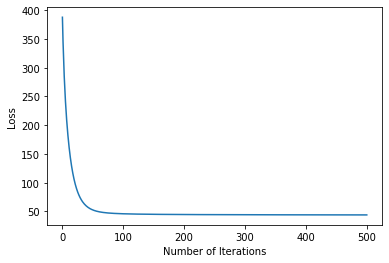

In [16]:
# ols model training

learningRate = 0.02
epochs = 501

model_ols = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','None')

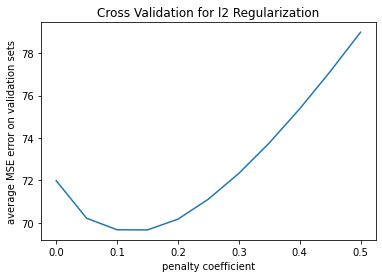

The best penalty coefficient is 0.15000000000000002
Time:  10.391608064
model trained using MSE loss
y-intercept  12.873053550720215
Coefficients  [[ 0.34263432  0.06393147 -0.07979822  0.6112578   0.15318274  0.41704902
   0.16769904  0.5927535   0.66314197 -0.84072363  0.37017274  2.1818185
   0.712468    0.6470762   5.434514   -1.9361153   2.324317    0.55317444
  -0.930611    6.194454    1.4630159  -1.1404741  -2.1956825  -0.7986935
  -1.1527323   0.04598478 -0.4717171  -0.60206616  0.5343753   0.32840845
  -0.16858907  0.939102    0.9499379   0.39242247 -0.06329697 -0.8125722 ]]
Train MSE = 45.894148595889106
Train R^2 = 0.7598997879854865
Train SPO Loss = [1493.76667332]


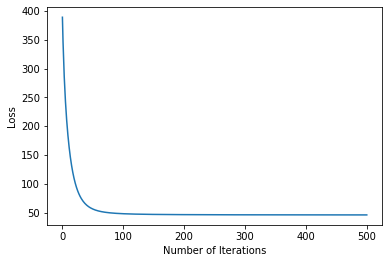

In [17]:
# ridge regression (l2 regrularization)

learningRate = 0.02
epochs = 501

# model training 

best_l2 = cross_validate(x_train, y_train, 'MSE', 'l2')
model_ridge = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','l2', l2_penalty = best_l2)

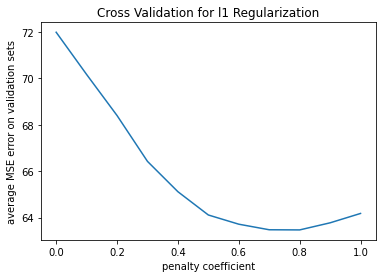

The best penalty coefficient is 0.8
Time:  14.896831101000004
model trained using MSE loss
y-intercept  13.838532447814941
Coefficients  [[-1.1412450e-03  1.3563287e-02  6.5867626e-03  4.4222480e-01
  -1.0767134e-02  1.9168778e-01  3.9352318e-03 -1.1635858e-02
   1.7986864e-02 -9.0064161e-02 -1.8609527e-03  1.3057604e+00
  -1.8364113e-02  1.8605527e-02  6.2399888e+00 -3.9734796e-01
   3.0105481e+00  5.4314572e-01 -3.5689884e-01  6.4317288e+00
   2.3125808e+00 -3.7938424e-03 -1.0289383e+00 -3.2584846e-01
   2.2861283e-04 -3.6833363e-03 -1.8694465e-01 -1.7374068e-01
   1.6011079e-01  9.2725560e-02 -1.7241452e-02  4.8406765e-01
   3.7138331e-01 -6.2337760e-03 -9.6760038e-04 -6.7938083e-01]]
Train MSE = 48.78445982545705
Train R^2 = 0.7447788115595428
Train SPO Loss = [1765.0527143]


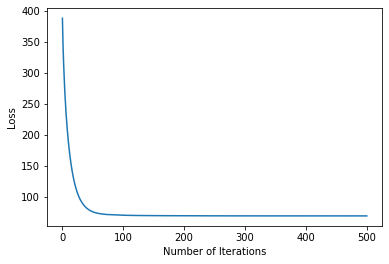

In [18]:
# l1 regularization (lasso) - penalty coefficient set to be 0.1

learningRate = 0.02
epochs = 501

best_l1 = cross_validate(x_train, y_train, 'MSE', 'l1')
model_lasso = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE', 'l1', l1_penalty = best_l1)

### MSE loss model evaluation

In [19]:
# compile results for models trained on MSE loss
MSE_result = []

for model, name in zip([model_ols, model_ridge, model_lasso],['mse_ols','mse_ridge','mse_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    MSE_result.append(pd.concat({name:score_df}))
    
MSE_scores = pd.concat([MSE_result[0], MSE_result[1],MSE_result[2]])
MSE_scores

MSE       R^2     SPO Loss  SPO Loss Ave
mse_ols   train   43.724713  0.771249  1710.147825      8.907020
          test   221.016194  0.589767   506.942417      8.592244
mse_ridge train   45.894149  0.759900  1493.766673      7.780035
          test   253.067885  0.530275   518.852746      8.794114
mse_lasso train   48.784460  0.744779  1765.052714      9.192983
          test   242.087701  0.550656   527.910712      8.947639

## SPO loss models

### SPO loss model training

/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


model trained using SPO loss
y-intercept  9.471031188964844
Coefficients  [[-3.1487286e-01 -4.3638736e-01 -4.3062994e-01  3.2471099e-01
  -1.0139402e-03  3.2728606e-01  3.8130319e-01 -7.6773755e-02
  -3.5879880e-01 -5.0351560e-01 -2.3518595e-01  5.6453937e-01
   3.0908313e-01 -6.5455461e-01  4.9858775e+00 -6.8590319e-01
   1.2850791e+00  1.0684723e+00 -1.1427641e-01  5.7976937e+00
   1.9548630e+00 -4.1426301e-01 -9.4650590e-01 -6.3168079e-01
  -6.0209066e-01  1.6213244e-01 -2.4267131e-01 -1.4216162e-01
   1.0823193e+00 -2.4461193e-01 -2.4523064e-01  3.6075482e-01
   2.6954398e-01  3.2005557e-01  2.1944055e-01 -7.6757506e-02]]
Train MSE = 80.70473561434359
Train R^2 = 0.5777844295097168
Train SPO Loss = [982.30435917]


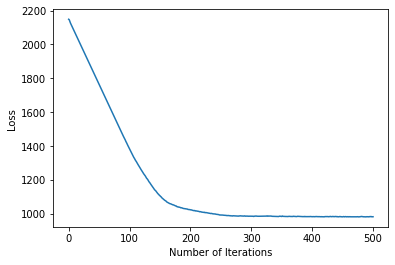

In [20]:
# ols

learningRate = 0.05
epochs = 501

# model training
model_ols2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','None')

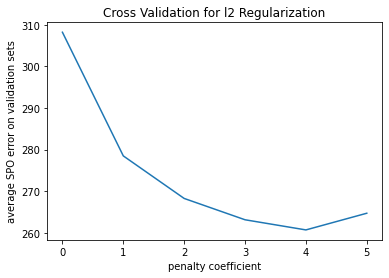

The best penalty coefficient is 4.0
Time:  111.26229416799998


/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


model trained using SPO loss
y-intercept  8.184385299682617
Coefficients  [[-1.40951291e-01 -2.37671301e-01 -3.19828480e-01  2.30489239e-01
  -1.20689953e-03  7.81154335e-02  2.46081725e-01 -1.31047055e-01
   4.44494076e-02 -3.70332658e-01  1.17169708e-01  5.61973631e-01
   2.98299372e-01 -7.91793764e-02  3.13760185e+00 -8.83832157e-01
   1.48995829e+00  4.02166128e-01 -4.43379641e-01  5.25500441e+00
   7.62389004e-01  1.22541033e-01 -1.03305566e+00 -6.43173456e-01
  -2.65839666e-01  2.02904806e-01 -2.52630264e-01 -1.99245717e-02
  -2.21518636e-01 -1.72575772e-01 -6.82232156e-02  2.92454839e-01
   1.07568376e-01  2.47403175e-01  2.34177038e-01  4.77765091e-02]]
Train MSE = 107.51792678741982
Train R^2 = 0.4375083140918583
Train SPO Loss = [1028.37225648]


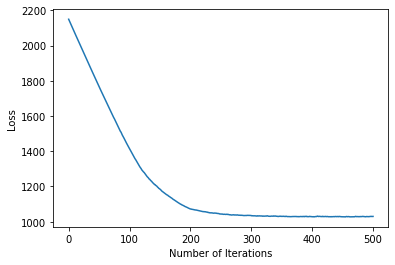

In [21]:
# ridge regression (l2 regrularization)

learningRate = 0.05
epochs = 501

# model training
best_l2_spo = cross_validate(x_train, y_train, 'SPO', 'l2')
model_ridge2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','l2', l2_penalty = best_l2_spo)

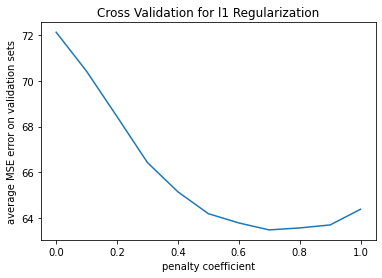

The best penalty coefficient is 0.7000000000000001
Time:  11.045101346000024
model trained using SPO loss
y-intercept  9.411511421203613
Coefficients  [[-2.20327914e-01 -4.05242652e-01 -4.33989316e-01  3.05483580e-01
   1.94459478e-03  1.50126040e-01  2.92483360e-01  6.65450618e-02
  -4.24954016e-03 -3.98153901e-01 -1.99847315e-02  6.52740240e-01
   2.95797229e-01 -2.37882406e-01  4.60394621e+00 -8.33721042e-01
   1.40523124e+00  7.70425737e-01 -2.98912376e-01  5.61319923e+00
   1.56273019e+00 -2.59251148e-01 -1.09379435e+00 -6.05494499e-01
  -2.88170218e-01  2.10172072e-01 -2.64995664e-01 -1.10265456e-01
   9.92158949e-01 -1.16512805e-01 -2.65413582e-01  2.47981489e-01
   6.26615435e-02  2.07239836e-01  8.15757439e-02 -1.19460881e-01]]
Train MSE = 82.73630859255987
Train R^2 = 0.5671560353087972
Train SPO Loss = [983.10011449]


/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


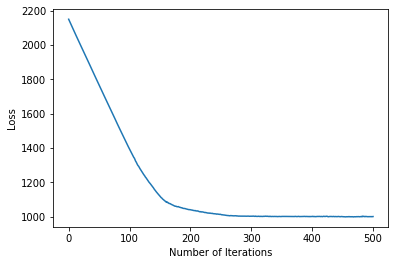

In [22]:
# l1 regularization (lasso)

learningRate = 0.05
epochs = 501

best_l1_spo = cross_validate(x_train, y_train, 'MSE', 'l1')
model_lasso2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO', 'l1', l1_penalty = best_l1_spo)

### SPO loss model evaluation

In [23]:
# compile results for models trained on SPO loss
SPO_result = []

for model, name in zip([model_ols2, model_ridge2, model_lasso2],['spo_ols','spo_ridge','spo_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    SPO_result.append(pd.concat({name:score_df}))
    
SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])
SPO_scores

MSE       R^2     SPO Loss  SPO Loss Ave
spo_ols   train   80.704736  0.577784   982.304359      5.116169
          test   369.102518  0.314901   594.665599     10.079078
spo_ridge train  107.517927  0.437508  1028.372256      5.356106
          test   440.739721  0.181934   658.194314     11.155836
spo_lasso train   82.736309  0.567156   983.100114      5.120313
          test   377.280962  0.299721   599.747262     10.165208

In [24]:
MSE_scores

MSE       R^2     SPO Loss  SPO Loss Ave
mse_ols   train   43.724713  0.771249  1710.147825      8.907020
          test   221.016194  0.589767   506.942417      8.592244
mse_ridge train   45.894149  0.759900  1493.766673      7.780035
          test   253.067885  0.530275   518.852746      8.794114
mse_lasso train   48.784460  0.744779  1765.052714      9.192983
          test   242.087701  0.550656   527.910712      8.947639

In [ ]:
# SPO MSE weighted loss
SPO_result = []

for model, name in zip([model_ols_spo_mse, model_ridge_spo_mse, model_lasso_spo_mse],['spo_mse_ols','spo_mse_ridge','spo_mse_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    SPO_result.append(pd.concat({name:score_df}))
    
SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])
SPO_scores

# References

In [25]:
%%script false --no-raise-error
import time
# Batch Gradient Descent Using Numpy - For comparison purpose

"""
code is based on Yuhan Cheng's code, approved use
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    alpha = 0.0
    beta = np.zeros((xvalue_matrix.shape[1],))
    epsilon = 0.00001
    n = float(len(xvalue_matrix))
    loss = []
    for i in range(MaxIterations):
        # compute new coefficients
        y_pred = alpha + np.matmul(xvalue_matrix, beta)
        loss.append(mean_squared_error(y_pred,yvalues))
#         if i % 100 == 0:
#             print('Current Loss:', loss)
        d_alpha = np.mean(y_pred - yvalues)
        d_beta = np.mean((y_pred - yvalues) * xvalue_matrix.T, axis = 1)
        alpha_1 = alpha - (R * d_alpha)
        beta_1 = beta - (R * d_beta)
        
        if np.isnan(alpha_1):
            print('nan at iter', str(i))
            break
        
        # check to see whether stopping criteria has been met
        if (np.abs(alpha_1-alpha)<epsilon) and np.all(np.abs(beta_1-beta)<epsilon):
            alpha, beta = alpha_1, beta_1
            print('error < epsilon, criteria met')
            break
        alpha, beta = alpha_1, beta_1
            
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print('MSE:', str(loss[-1]))
    print('R2:', str(r2_score(y_true=yvalues, y_pred = y_pred)))
    
    plt.plot(range(len(loss)),loss)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()
    return alpha, beta

Ref:
Lineary Regression with Pytorch
  
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  
  https://www.reneshbedre.com/blog/pytorch-regression.html
  
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
  
Evaluations:

  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
  
Quick Ordinary Lineary Regression Calculator:

  https://www.socscistatistics.com/tests/regression/default.aspx
